# Setting up a relative hydration free energy network

This tutorial gives a step-by-step process to set up a relative hydration free energy (RHFE) simulation campaign. This will create the same network as created in the accompanying CLI tutorial. It assumes that you have already done the CLI tutorial.

With the CLI, all the steps here were performed by the `openfe plan-rhfe-network` command. However, that command offers little room for customization. Using the Python interface gives us the ability to customize all aspects of how our simulation runs.

In [1]:
%matplotlib inline
import openfe

## Loading the molecules

In [2]:
# TODO: simplify ligand loading
from rdkit import Chem
supp = Chem.SDMolSupplier("./molecules/rhfe/benzenes_RHFE.sdf", removeHs=False)
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]

name_to_ligand = {ligand.name: ligand for ligand in ligands}

## Creating the `LigandNetwork`

The first step is to create a `LigandNetwork`, which is a network with small molecules as nodes, and atom mappings, the description of how to alchemically mutate between the molecules, as its edges.

The pipeline for creating a `LigandNetwork` can involve three components:

* **Atom Mapper**: Proposes potential atom mappings (descriptions of the alchemical change) for pairs of ligands. We will use the `LomapAtomMapper`.
* **Scorer**: Given an atom mapping, provides an estimate of the quality of that mapping (lower scores are better). We will use `default_lomap_scorer`.
* **Network Planner**: Creates the actual `LigandNetwork`; different network planners provide different strategies. We will create a minimal spanning network with the `generate_minimal_spanning_network` method.

Each of these components could be replaced by other options.

In [3]:
mapper = openfe.LomapAtomMapper()
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

The exact call signature depends on the network planner: a minimal spanning network requires a score, whereas that is optional for a radial network (but a radial network needs the central ligand to be provided).

In [4]:
ligand_network = network_planner(
    ligands=ligands,
    mappers=[mapper],
    scorer=scorer
)

Now we can look at the overall structure of the `LigandNetwork`:

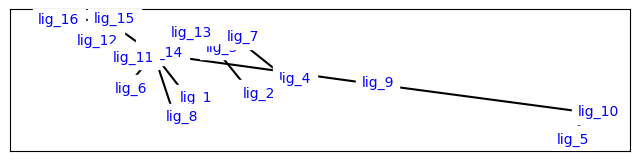

In [5]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

We can also inspect the individual atom mappings:

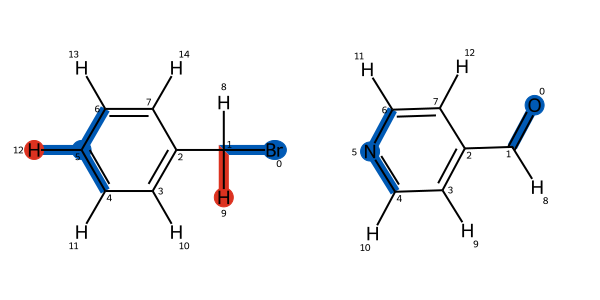

In [6]:
# get the first edge; it automatically displays in a Jupyter notebook
mapping = next(iter(ligand_network.edges))
mapping

## Creating a single `Transformation`

The `LigandNetwork` only knows about the small molecules and the alchemical connections between them. It doesn't know anything about environment (e.g., solvent) or about the `Protocol` that will be used during the simulation.

That information in included in a `Transformation`. Each transformation corresponds to a single leg of the simulation campaign, so for each edge in the `LigandNetwork`, we will create two `Transformation`s: one for vacuum and one for solvent.

In practice, this will be done for each edge of the `LigandNetwork` in a loop, but for illustrative purposes we'll dive into the details of creating a single transformation. In particular, we'll create the solvent leg for the pair of molecules we selecting for the mapping above.

### Creating `ChemicalSystem`s

OpenFE describes complex molecular systems as being composed of `Component`s. For example, we have `SmallMoleculeComponent` for each small molecule in the `LigandNetwork`. We'll create a `SolventComponent` to describe the solvent, and binding free energy calculations involve a `ProteinComponent`.

The `Component`s are joined in a `ChemicalSystem`, which describes all the particles in the simulation.

In [7]:
# defaults are water with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [8]:
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent
})

### Creating a `Protocol`

The actual simulation is performed by a `Protocol`. We'll use an OpenMM-based hybrid topology relative free energy `Protocol`.

In [9]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol


The easiest way to customize protocol settings is to start with the default settings, and modify them. Many settings carry units with them.

In [10]:
settings = RelativeHybridTopologyProtocol.default_settings()
settings.thermo_settings.temperature  # display default value

298.15 <Unit('kelvin')>

In [11]:
from openff.units import unit

# change the value
settings.thermo_settings.temperature = 310 * unit.kelvin

We'll use the default settings for the protocol we'll use later, to match the behavior of the CLI.

In [12]:
default_settings = RelativeHybridTopologyProtocol.default_settings()
protocol = RelativeHybridTopologyProtocol(default_settings)

### Creating the `Transformation`

Once we have the mapping, the two `ChemicalSystem`s, and the `Protocol`, creating the `Transformation` is easy:

In [13]:
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping={'ligand': mapping},
)

## Creating the `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each leg of the campaign. We'll loop over all the mappings, and them loop over the legs. In that inner loop, we'll make each transformation.

In [14]:
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'vacuum']:
        sysA_dict = {'ligand': mapping.componentA}
        sysB_dict = {'ligand': mapping.componentB}
        if leg == 'solvent':
            # use the solvent created above
            sysA_dict['solvent'] = solvent
            sysB_dict['solvent'] = solvent
        
        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

## Writing the `AlchemicalNetwork` to disk

We'll write out each transformation to disk, so that they can be run independently using the `openfe quickrun` command:

In [15]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

In [16]:
!ls transformations/

lig_11_solvent_lig_16_solvent.json lig_3_vacuum_lig_13_vacuum.json
lig_11_vacuum_lig_16_vacuum.json   lig_4_solvent_lig_7_solvent.json
lig_12_solvent_lig_15_solvent.json lig_4_vacuum_lig_7_vacuum.json
lig_12_vacuum_lig_15_vacuum.json   lig_5_solvent_lig_10_solvent.json
lig_13_solvent_lig_14_solvent.json lig_5_vacuum_lig_10_vacuum.json
lig_13_vacuum_lig_14_vacuum.json   lig_6_solvent_lig_14_solvent.json
lig_14_solvent_lig_15_solvent.json lig_6_vacuum_lig_14_vacuum.json
lig_14_vacuum_lig_15_vacuum.json   lig_7_solvent_lig_13_solvent.json
lig_15_solvent_lig_16_solvent.json lig_7_vacuum_lig_13_vacuum.json
lig_15_vacuum_lig_16_vacuum.json   lig_8_solvent_lig_14_solvent.json
lig_1_solvent_lig_14_solvent.json  lig_8_vacuum_lig_14_vacuum.json
lig_1_vacuum_lig_14_vacuum.json    lig_9_solvent_lig_10_solvent.json
lig_2_solvent_lig_3_solvent.json   lig_9_solvent_lig_14_solvent.json
lig_2_vacuum_lig_3_vacuum.json     lig_9_vacuum_lig_10_vacuum.json
lig_3_solvent_lig_13_solvent.json  lig_9_vacuum_li